# Comparing CC3 and CC2

Notebook to check how CC2 and CC3 models compare, because currently the results coming out look wrong.

In [1]:
cc2_showerflow_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_best.pth"
cc3_showerflow_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_best.pth"
#cc3_showerflow_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_best.pth"
#cc3_showerflow_path = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_original_nb10_inputs8070450532247928831_fnorms_best.pth"

cc2_diffusion_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/from_anatoli/CC2/CD_2023_07_07__16_32_09/ckpt_0.000000_1120000.pt"
cc3_diffusion_path = "/data/dust/user/dayhallh/point-cloud-diffusion-logs/sim-E1261AT600AP180-180/Anatoliis_cc_2.pt"

from pointcloud.config_varients import caloclouds_3_simple_shower, caloclouds_2
from pointcloud.evaluation.bin_standard_metrics import get_caloclouds_models

cc_models = get_caloclouds_models(cc2_diffusion_path, cc2_showerflow_path, caloclouds_names="CC2", configs=caloclouds_2.Configs())
cc_models.update(get_caloclouds_models(cc3_diffusion_path, cc3_showerflow_path, caloclouds_names="CC3", configs=caloclouds_3_simple_shower.Configs()))
print(cc_models.keys())


/data/dust/user/dayhallh/point-cloud-diffusion-logs/from_anatoli/CC2/CD_2023_07_07__16_32_09/ckpt_0.000000_1120000.pt
Found 1 saved models
/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_best.pth
/data/dust/user/dayhallh/point-cloud-diffusion-logs/sim-E1261AT600AP180-180/Anatoliis_cc_2.pt
original_nb4_fnorms_wo[0, 1, 4] has best loss -145.9351401815609
alt1_nb4_fnorms_wo[0, 1, 4] has best loss -147.62754416952328
Found 10 saved models
/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_best.pth
dict_keys(['CC2', 'CC3'])


Now get some sample conditioning values with which to compare the models.
The same ones will be used for both models, however, the expected scaling may be different.


In [2]:
from pointcloud.data.conditioning import read_raw_regaxes_withcond
all_cond = caloclouds_3_simple_shower.Configs()
all_cond = caloclouds_2.Configs()
all_cond.dataset_path_in_storage = False
all_cond.dataset_path = "/data/dust/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5"
all_cond.n_dataset_files = 10
all_cond.cond_features_names = ["energy", "points", "p_norm_local"]
all_cond.cond_features = 5
if True:
    cond, events = read_raw_regaxes_withcond(all_cond, total_size=1_000, for_model=['diffusion'])
print(cond[:10])


Selecting evenly spaced events
tensor([[4.3710e+01, 2.8140e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.2829e+01, 9.9600e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [6.7785e+01, 4.1160e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.4652e+01, 1.0870e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.9282e+01, 1.4110e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [7.2836e+01, 4.1840e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.5205e+01, 1.8940e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [5.7934e+01, 2.4680e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [7.3653e+01, 4.1410e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.8710e+01, 2.0940e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00]],
       dtype=torch.float64)


Make cond for both CC2 and CC3


In [3]:
from pointcloud.data.conditioning import normalise_cond_feats
from pointcloud.utils.metadata import Metadata
meta = Metadata(all_cond)
original_cc2_max_points = 6_000
normalised_cond = cond.clone()
normalised_cond[:, 3] = 0
normalised_cond[:, 4] = 1
normalised_cond[:, 0] /= meta.incident_rescale
normalised_cond[:, 1] = (normalised_cond[:, 1]/original_cc2_max_points)*2 - 1
showerflow_cond = {"CC2": normalised_cond[:, [0]], "CC3": normalised_cond[:, [0, 2, 3, 4]]}
# for the diffusion models, the energy goes between -1 and 1
normalised_cond[:, 0] = normalised_cond[:, 0]*2 - 1
diffusion_cond = {"CC2": normalised_cond[:, [0, 1]], "CC3":showerflow_cond["CC3"]}

In [4]:
conditioned_samples = {}
point_per_event = 100
for name in cc_models:
    diffusion, flow_dist, configs = cc_models[name]
    d_cond = diffusion_cond[name].float()
    s_diffusion = diffusion.sample(d_cond, point_per_event, all_cond)
    s_cond = showerflow_cond[name].float()
    s_showerflow = flow_dist.condition(s_cond).sample([len(s_cond)])
    conditioned_samples[name] = (s_diffusion, s_showerflow)

    

In [5]:
# WRONG, this makes the CC3 showers all wonky
if False:
    conditioned_samples2 = {}
    normalised_cond2 = normalised_cond.clone()
    normalised_cond2[:, 3] = 1
    normalised_cond2[:, 4] = 0
    showerflow_cond2 = {"CC2": normalised_cond2[:, [0]], "CC3": normalised_cond2[:, [0, 2, 3, 4]]}
    diffusion_cond2 = {"CC2": normalised_cond2[:, [0, 1]], "CC3":showerflow_cond2["CC3"]}
    point_per_event = 100
    for name in cc_models:
        diffusion, flow_dist, configs = cc_models[name]
        d_cond = diffusion_cond2[name].float()
        s_diffusion = diffusion.sample(d_cond, point_per_event, all_cond)
        s_cond = showerflow_cond2[name].float()
        s_showerflow = flow_dist.condition(s_cond).sample([len(s_cond)])
        conditioned_samples2[name] = (s_diffusion, s_showerflow)
    
        

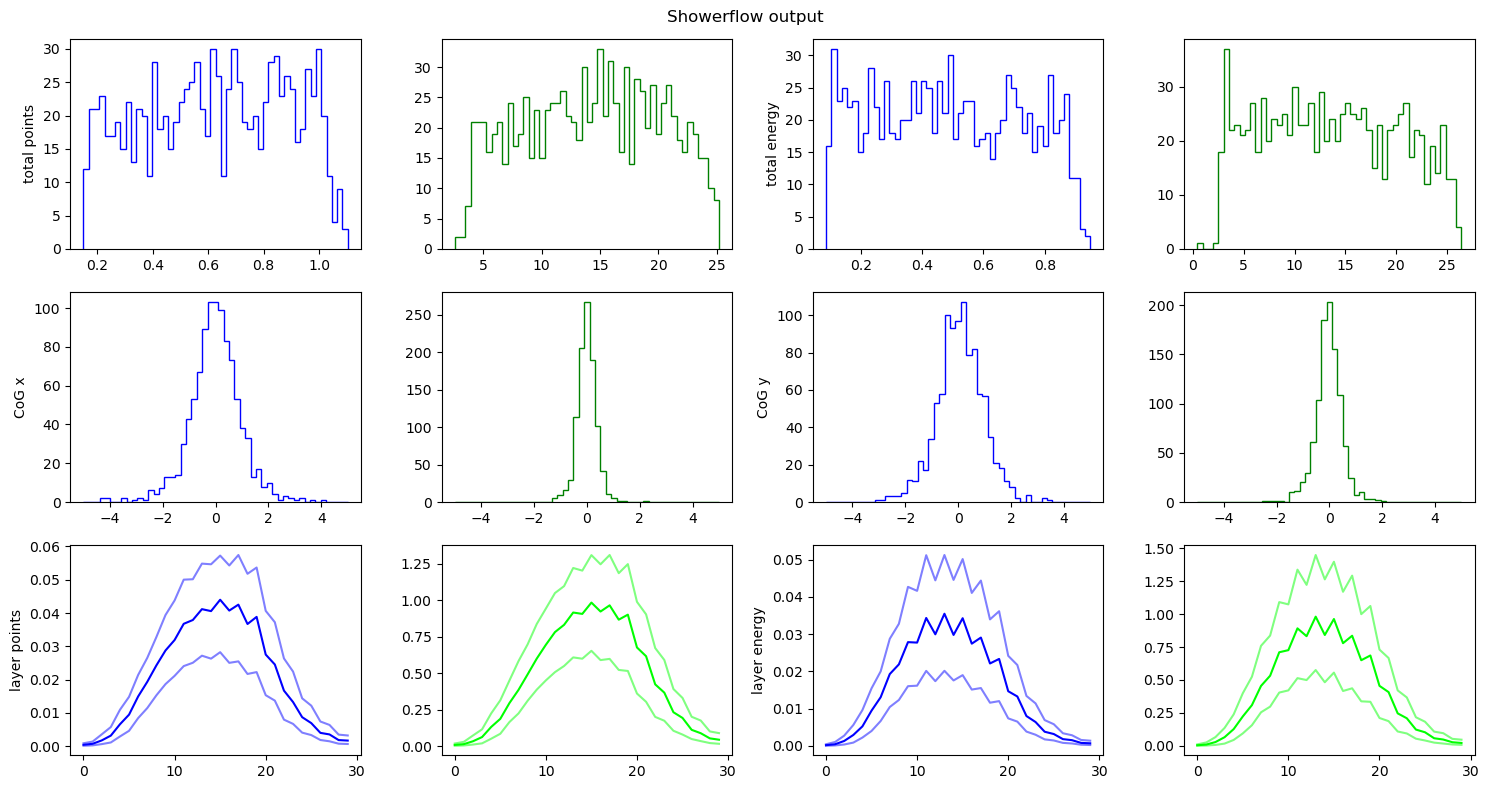

In [6]:
from matplotlib import pyplot as plt
import numpy as np
fig, ax_arr = plt.subplots(3, 4, figsize=(15, 8))
ax_arr = ax_arr.flatten()
fig.suptitle("Showerflow output")
hist2_settings = dict(label='CC2', color='blue', histtype="step", bins=np.linspace(-5, 5, 50))
hist3_settings = dict(label='CC3', color='green', histtype="step", bins=np.linspace(-5, 5, 50))


i=4
ax_arr[i].set_ylabel("CoG x")
cc2_v = conditioned_samples["CC2"][1][:, 4]
cc3_v = conditioned_samples["CC3"][1][:, 0]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=6
ax_arr[i].set_ylabel("CoG y")
cc2_v = conditioned_samples["CC2"][1][:, 2]
cc3_v = conditioned_samples["CC3"][1][:, 1]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=0
# total points
hist2_settings['bins'] = 50
hist3_settings['bins'] = 50
ax_arr[i].set_ylabel("total points")
cc2_v = conditioned_samples["CC2"][1][:, 0]
cc3_v = conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1)

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=8
ax_arr[i].set_ylabel("layer points")
layer_pnts2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -60:-30]
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_pnts3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_pnts2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_pnts3[:, l] = np.quantile(conditioned_samples["CC3"][1][:, -60+l], quantiles)
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i+1].plot(range(30), layer_pnts3[j], color=colour[j])



i=2
# total energy
ax_arr[i].set_ylabel("total energy")
cc2_v = conditioned_samples["CC2"][1][:, 1]
cc3_v = conditioned_samples["CC3"][1][:, -30:].sum(dim=1)

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i+1].hist(cc3_v, **hist3_settings)

i=10
ax_arr[i].set_ylabel("layer energy")
layer_e2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -30:]
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_e3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_e2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_e3[:, l] = np.quantile(conditioned_samples["CC3"][1][:, -30+l], quantiles)
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i+1].plot(range(30), layer_e3[j], color=colour[j])

plt.tight_layout()

In [7]:
n_pnts = (events[..., -1] > 0).sum(axis=1)
energy = events[..., -1].sum(axis=1)/meta.vis_eng_rescale
cog_x = ((events[..., -1]*events[..., 0]/events[..., [-1]].sum(axis=1)).sum(axis=1)-meta.mean_cog[0])/meta.std_cog[0]
cog_y = ((events[..., -1]*events[..., 1]/events[..., [-1]].sum(axis=1)).sum(axis=1)-meta.mean_cog[1])/meta.std_cog[1]


In [45]:
np.max(n_pnts)

np.int64(5507)

In [60]:
print(meta.n_pts_rescale, meta.std_cog)
meta3 = Metadata(caloclouds_3_simple_shower.Configs())
old_rescale = meta3.n_pts_rescale
meta3 = Metadata(all_cond)
# TODO.... how to actually get this rescale right?
meta3.n_pts_rescale = (old_rescale*meta.n_pts_rescale)/float(np.max(n_pnts))
meta3.std_cog = np.array([np.std(cog_x), np.std(cog_y), 2.])
print(meta3.n_pts_rescale, meta3.std_cog)


5000 [1. 1. 1.]
7140.00363174142 [0.93711166 1.00698206 2.        ]


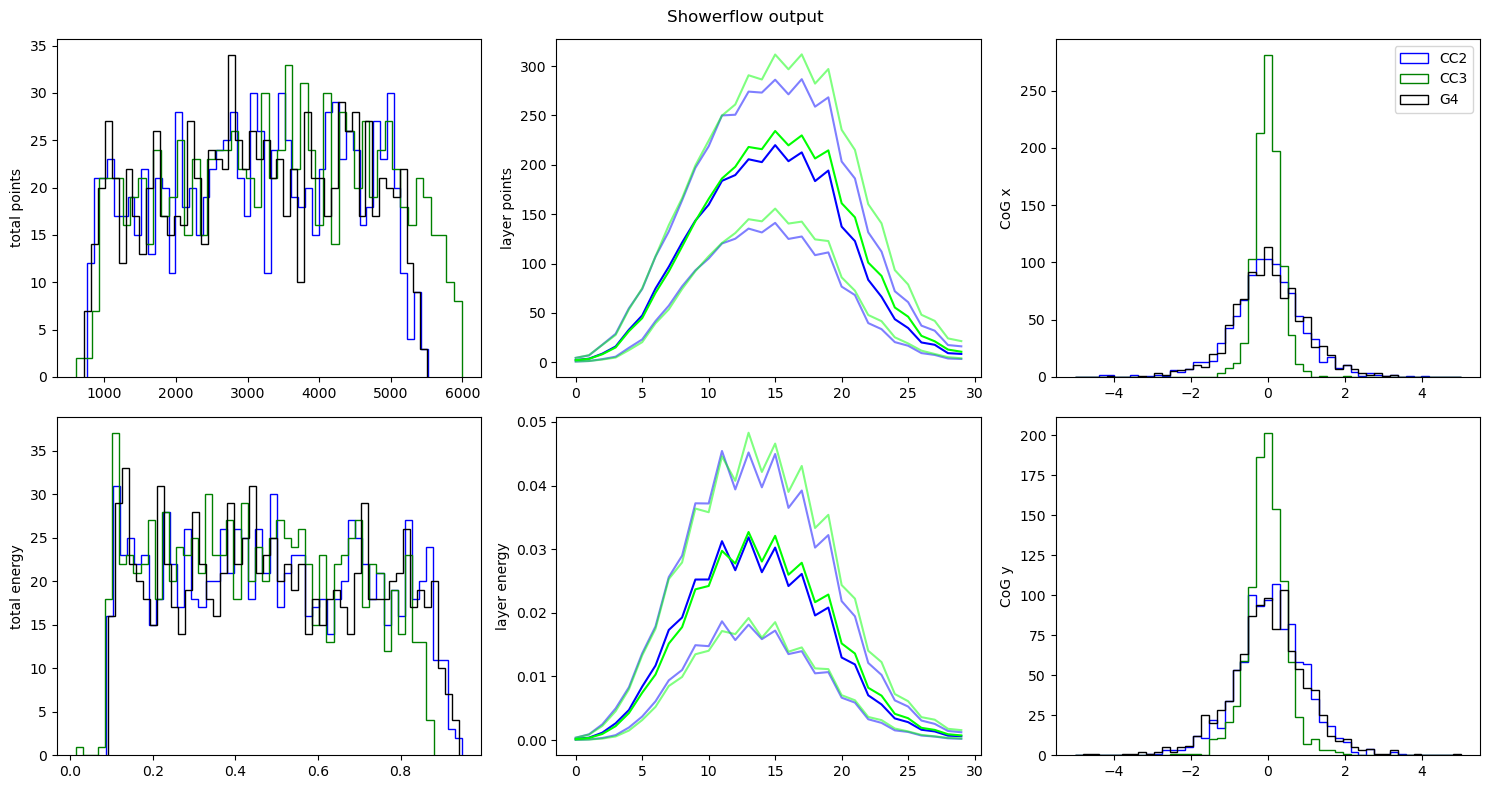

In [61]:
from matplotlib import pyplot as plt
fig, ax_arr = plt.subplots(2, 3, figsize=(15, 8))
ax_arr = ax_arr.flatten()
fig.suptitle("Showerflow output")
hist2_settings = dict(label='CC2', color='blue', histtype="step", bins=np.linspace(-5, 5, 50))
hist3_settings = dict(label='CC3', color='green', histtype="step", bins=np.linspace(-5, 5, 50))
histg4_settings = dict(label='G4', color='k', histtype='step', bins=np.linspace(-5, 5, 50))

i=2
ax_arr[i].set_ylabel("CoG x")
cc2_v = conditioned_samples["CC2"][1][:, 4]*meta.std_cog[0]
cc3_v = conditioned_samples["CC3"][1][:, 0]*meta3.std_cog[0]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_x, **histg4_settings)
ax_arr[i].legend()

i=5
ax_arr[i].set_ylabel("CoG y")
cc2_v = conditioned_samples["CC2"][1][:, 2]*meta.std_cog[1]
cc3_v = conditioned_samples["CC3"][1][:, 1]*meta3.std_cog[1]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_y, **histg4_settings)

i=0
# total points
hist2_settings['bins'] = 50
hist3_settings['bins'] = 50
histg4_settings['bins'] = 50
ax_arr[i].set_ylabel("total points")
cc2_v = (float(meta.n_pts_rescale)*conditioned_samples["CC2"][1][:, 0]).clip(1, 60_000)
cc3_v = float(meta3.n_pts_rescale)*conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(n_pnts, **histg4_settings)

i=1
ax_arr[i].set_ylabel("layer points")
layer_pnts2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -60:-30].clip(0, 1)
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_pnts3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_pnts2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_pnts3[:, l] = float(meta3.n_pts_rescale)*np.quantile(conditioned_samples["CC3"][1][:, -60+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts3[j], color=colour[j])



i=3
# total energy
ax_arr[i].set_ylabel("total energy")
cc2_v = conditioned_samples["CC2"][1][:, 1]
cc3_v = conditioned_samples["CC3"][1][:, -30:].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(energy, **histg4_settings)

i=4
ax_arr[i].set_ylabel("layer energy")
layer_e2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -30:].clip(0, 1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_e3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_e2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_e3[:, l] = np.quantile(conditioned_samples["CC3"][1][:, -30+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e3[j], color=colour[j])

plt.tight_layout()

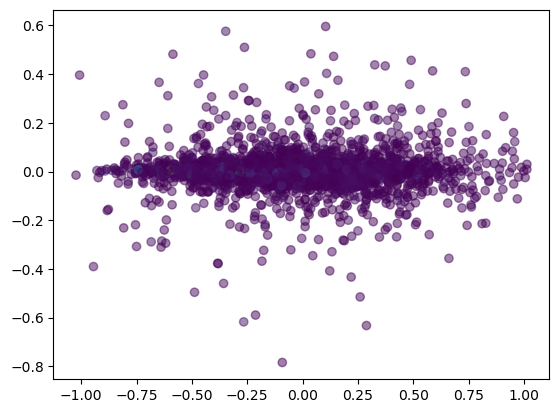

In [10]:
import torch
n = 0.6
e = 0.5
diffusion_m, sf_m, configs_m = cc_models["CC2"]
fake_shower = diffusion_m.sample(torch.tensor([[e, n]]), 2500, configs)
fake_shower = fake_shower.detach()

plt.scatter(fake_shower[0, :, 1], fake_shower[0, :, 2], alpha=0.5, c=fake_shower[0, :, 3])

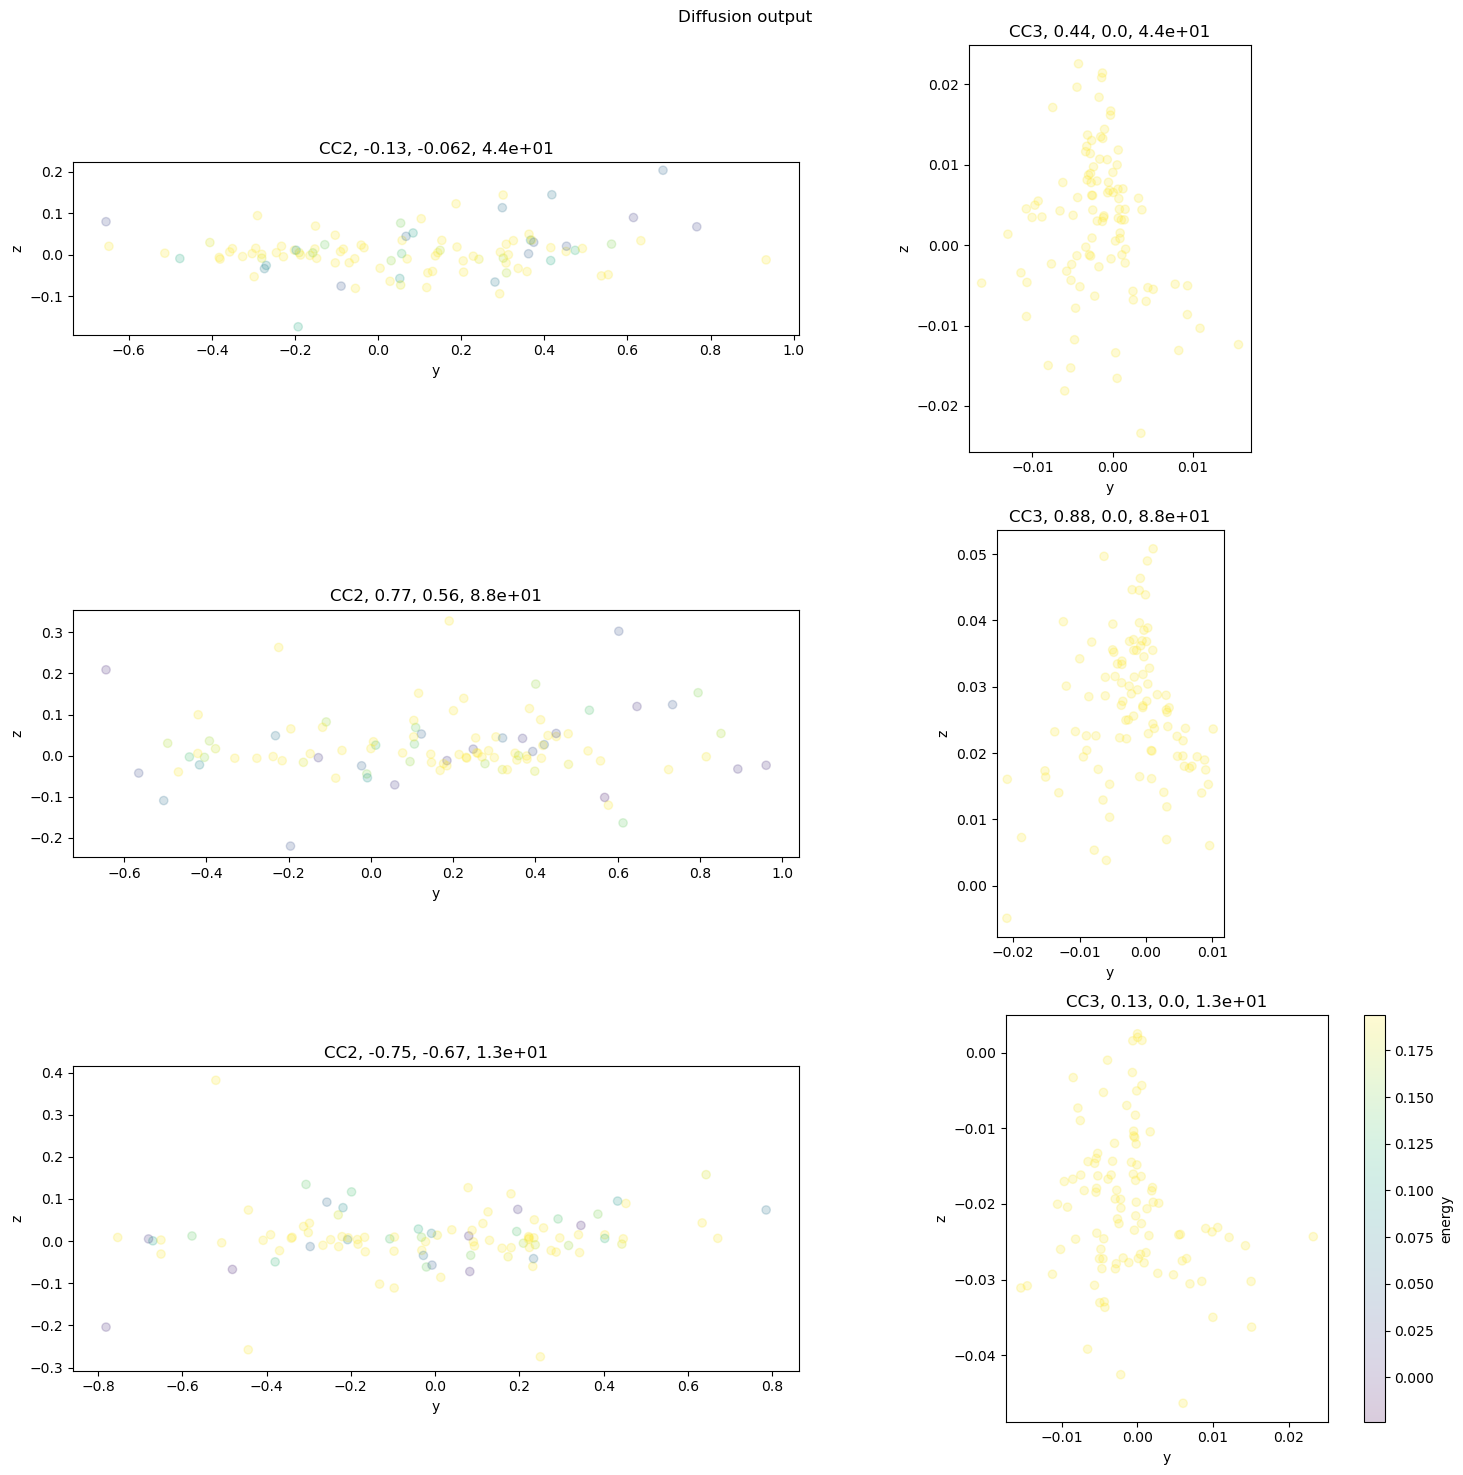

In [11]:
from matplotlib import pyplot as plt
min_energy = min(conditioned_samples["CC2"][0][..., -1].min(),
                 conditioned_samples["CC3"][0][..., -1].min())
max_energy = max(conditioned_samples["CC2"][0][..., -1].max(),
                 conditioned_samples["CC3"][0][..., -1].max())*0.01
use_events = [0, 50, 99]
fig, ax_arr = plt.subplots(len(use_events), 2, figsize=(15, len(use_events)*5))
fig.suptitle("Diffusion output")
for e, event in enumerate(use_events):
    for i, name in enumerate(conditioned_samples):
        s_diffusion, s_showerflow = conditioned_samples[name]
        s_diffusion = s_diffusion.detach()
        ax_arr[e, i].set_aspect(1)
        points = ax_arr[e, i].scatter(s_diffusion[event, :, 1], s_diffusion[event, :, 2], c=s_diffusion[event, :, 3], alpha=0.2, vmin=min_energy, vmax=max_energy)
        ax_arr[e, i].set_title(f"{name}, {diffusion_cond[name][event, 0]:.2}, {diffusion_cond[name][event, 1]:.2}, {cond[event, 0]:.2}")
        ax_arr[e, i].set_xlabel("y")
        ax_arr[e, i].set_ylabel("z")
cbar = plt.colorbar(points)
cbar.set_label("energy")
plt.tight_layout()

In [12]:
from pointcloud.utils.showerflow_utils import truescale_showerflow_output
model_name = "CC2"
diffusion_m, sf_m, configs_m = cc_models[model_name]

import ipdb
if True:
    meta = Metadata(all_cond)
    #ipdb.set_trace()
    meta.n_pts_rescale = 5000
    meta.vis_eng_rescale = 1
    meta.std_cog[:] = 1
    meta.mean_cog[:] = 0
    np_ts, energy_ts, cog_x_ts, cog_y_ts, cog_z_ts, clusters_per_layer_ts, e_per_layer_ts = truescale_showerflow_output(conditioned_samples[model_name][1].clone(), configs_m, meta)
    if np_ts is None:
        np_ts = clusters_per_layer_ts.sum(dim=1)
    if energy_ts is None:
        energy_ts = e_per_layer_ts.sum(dim=1)
print(np_ts.mean(), cog_x_ts.mean(), cog_y_ts.mean(), clusters_per_layer_ts.mean(), e_per_layer_ts.mean())

tensor(3115.2087) tensor(0.0688) tensor(-0.0224) tensor(0.4184) tensor(0.3753)


In [22]:
from pointcloud.utils.gen_utils import gen_cond_showers_batch
# CC2
cond_m = {"showerflow":cond[:, [0]], "diffusion": cond[:, [0, 1]]}
diffusion_m, sf_m, configs_m = cc_models["CC2"]
all_cond.device='cpu'
import ipdb
if True:
    #ipdb.set_trace()
    events = gen_cond_showers_batch(diffusion_m, sf_m, cond_m, config=all_cond, metadata=meta)

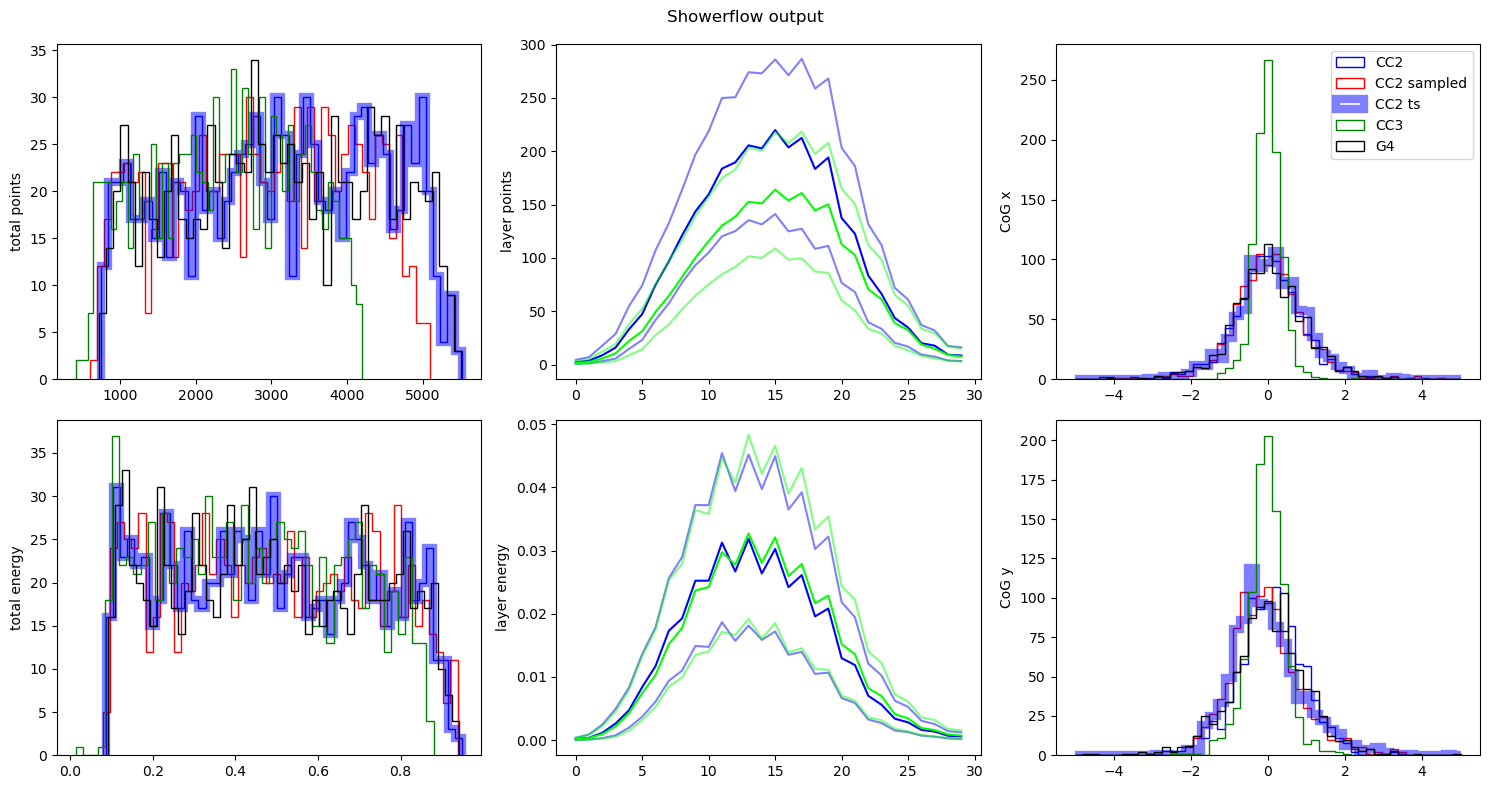

In [23]:
total_points_s = (events[:, :, 3] > 0).sum(axis=1)
total_energy_s = events[:, :, 3].sum(axis=1)/1000
cog_x_s = ((events[..., -1]*events[..., 0]/events[..., [-1]].sum(axis=1)).sum(axis=1)-meta.mean_cog[0])/meta.std_cog[0]
cog_y_s = ((events[..., -1]*events[..., 1]/events[..., [-1]].sum(axis=1)).sum(axis=1)-meta.mean_cog[1])/meta.std_cog[1]
from matplotlib import pyplot as plt
fig, ax_arr = plt.subplots(2, 3, figsize=(15, 8))
ax_arr = ax_arr.flatten()
fig.suptitle("Showerflow output")
hist2_settings = dict(label='CC2', color='blue', histtype="step", bins=np.linspace(-5, 5, 50))
hist2s_settings = dict(label='CC2 sampled', color='red', histtype="step", bins=np.linspace(-5, 5, 50))
hist2ts_settings = dict(label=f'{model_name} ts', color='blue', histtype="step", linewidth=6, alpha=0.5, bins=np.linspace(-5, 5, 50))
hist3_settings = dict(label='CC3', color='green', histtype="step", bins=np.linspace(-5, 5, 50))
histg4_settings = dict(label='G4', color='k', histtype='step', bins=np.linspace(-5, 5, 50))
settings = [hist2_settings, hist2s_settings, hist2ts_settings, hist3_settings, histg4_settings]

i=2
ax_arr[i].set_ylabel("CoG x")
cc2_v = conditioned_samples["CC2"][1][:, 4]
cc3_v = conditioned_samples["CC3"][1][:, 0]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cog_x_s, **hist2s_settings)
ax_arr[i].hist(cog_x_ts, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_x, **histg4_settings)
ax_arr[i].legend()

i=5
ax_arr[i].set_ylabel("CoG y")
cc2_v = conditioned_samples["CC2"][1][:, 2]
cc3_v = conditioned_samples["CC3"][1][:, 1]

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(cog_y_s, **hist2s_settings)
ax_arr[i].hist(cog_y_ts, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(cog_y, **histg4_settings)

i=0
# total points
for seti in settings:
    seti['bins'] = 50
ax_arr[i].set_ylabel("total points")
cc2_v = (float(meta.n_pts_rescale)*conditioned_samples["CC2"][1][:, 0]).clip(1, 60_000)
cc3_v = float(meta.n_pts_rescale)*conditioned_samples["CC3"][1][:, -60:-30].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(total_points_s, **hist2s_settings)
ax_arr[i].hist(np_ts, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(n_pnts, **histg4_settings)

i=1
ax_arr[i].set_ylabel("layer points")
layer_pnts2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -60:-30].clip(0, 1)
raw_totals = raw.sum(dim=1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_pnts3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_pnts2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_pnts3[:, l] = float(meta.n_pts_rescale)*np.quantile(conditioned_samples["CC3"][1][:, -60+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_pnts3[j], color=colour[j])



i=3
# total energy
ax_arr[i].set_ylabel("total energy")
cc2_v = conditioned_samples["CC2"][1][:, 1]
cc3_v = conditioned_samples["CC3"][1][:, -30:].sum(dim=1)/30

ax_arr[i].hist(cc2_v, **hist2_settings)
ax_arr[i].hist(total_energy_s, **hist2s_settings)
ax_arr[i].hist(energy_ts/1000, **hist2ts_settings)
ax_arr[i].hist(cc3_v, **hist3_settings)
ax_arr[i].hist(energy, **histg4_settings)

i=4
ax_arr[i].set_ylabel("layer energy")
layer_e2 = np.zeros((3, 30))
raw = conditioned_samples["CC2"][1][:, -30:].clip(0, 1)
renormed = raw*(cc2_v[:, None]/raw_totals[:, None])
layer_e3 = np.zeros((3, 30))
quantiles = [0.25, 0.5, 0.75]
for l in range(30):
    layer_e2[:, l] = np.quantile(renormed[:, l], quantiles)
    layer_e3[:, l] = np.quantile(conditioned_samples["CC3"][1][:, -30+l], quantiles)/30
colour = ((0, 0, 1, 0.5), (0, 0, 1, 1), (0, 0, 1, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e2[j], color=colour[j])
colour = ((0, 1, 0, 0.5), (0, 1, 0, 1), (0, 1, 0, 0.5))
for j in range(3):
    ax_arr[i].plot(range(30), layer_e3[j], color=colour[j])

plt.tight_layout()